## 1. Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


## 2. Load and Clean the Dataset

We are using the Adult Income dataset. In this step:
- We assign column names
- Load the data while replacing missing values (marked as " ?")
- Drop rows with missing data
- Encode the target (`income`)
- Apply one-hot encoding to categorical variables


In [2]:
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
           'marital-status', 'occupation', 'relationship', 'race', 'sex',
           'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']

df = pd.read_csv('/content/adult_moins.csv', header=None, names=columns,
                 na_values=' ?', skipinitialspace=True)

print("Missing values before cleaning:")
print(df.isnull().sum())

df.dropna(inplace=True)
df['income'] = df['income'].apply(lambda x: 1 if x == '>50K' else 0)

categorical_cols = df.select_dtypes(include=['object']).columns
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)


Missing values before cleaning:
age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64


## 3. Feature Scaling and Data Splitting

We standardize the feature set using `StandardScaler`, then split into train and test sets.


In [3]:
X = df_encoded.drop('income', axis=1)
y = df_encoded['income']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42)


## 4. Train Random Forest on Full Feature Space

We train a RandomForestClassifier on all dimensions and evaluate its performance.



 Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.98      0.91        41
           1       0.67      0.22      0.33         9

    accuracy                           0.84        50
   macro avg       0.76      0.60      0.62        50
weighted avg       0.82      0.84      0.81        50


 Accuracy Score: 0.84


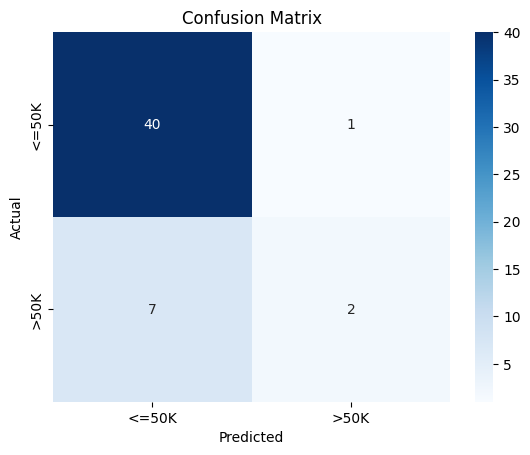

In [4]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print("\n Classification Report:\n")
print(classification_report(y_test, y_pred))
print("\n Accuracy Score:", accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['<=50K','>50K'], yticklabels=['<=50K','>50K'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


## 5. Dimensionality Reduction with PCA (2D)

We use PCA to reduce our dataset to 2 components so that we can visualize decision boundaries.


In [5]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
X_pca_train, X_pca_test = train_test_split(X_pca, test_size=0.2, random_state=42)


## 6. Train Random Forest on 2D PCA Data

We train another Random Forest classifier, but only on the 2D PCA data.


In [6]:
rf_2d = RandomForestClassifier(n_estimators=100, random_state=42)
rf_2d.fit(X_pca_train, y_train)


RandomForestClassifier(random_state=42)

## 7. Visualize 2D Decision Boundary

We use a scatter plot to display the PCA-reduced data and overlay the decision boundary of the trained model.


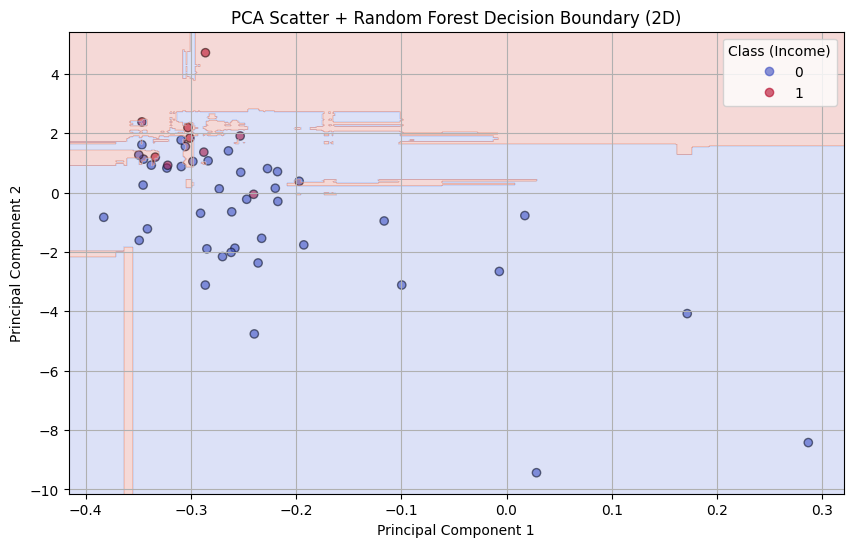

In [7]:
plt.figure(figsize=(10,6))
scatter = plt.scatter(X_pca_test[:, 0], X_pca_test[:, 1],
                      c=y_test, cmap='coolwarm', alpha=0.6, edgecolors='k')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter + Random Forest Decision Boundary (2D)')
plt.legend(*scatter.legend_elements(), title="Class (Income)")
plt.grid(True)

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 500),
                     np.linspace(ylim[0], ylim[1], 500))
xy = np.vstack([xx.ravel(), yy.ravel()]).T
Z = rf_2d.predict(xy).reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.2, cmap='coolwarm')
plt.show()
